In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import random
import math
import h5py

In [2]:
WN = np.loadtxt('W_avg.csv') ### not symmetric!! travel out is added up tp zero, travel in is not add to zero
Cave = np.loadtxt('Cave.csv')
pop = np.loadtxt('pop_new.csv')

In [3]:
num_fips = len(pop)
T = 60
num_ens = 300
Z = 3 # latent period
Zb = 1 # scale parameter for Z
D = 5 # infectious period
Db = 1 # scale parameter for b
alpha = 0.1 # reporting rate 10%
# seeding
l0 = 1859-1 # start with New York County NY in python -1, in matlab is 1859
i0 = 100 ## the starting t=0, in matlab it is 1
initials = (l0,i0)
R0=2.5

In [4]:
def state_M(M,states):
    N = M.shape[0]
    state_outflow = (np.sum(M,axis=0)-np.diag(M))*states  ### sum up the prob and then sum the value
    state_in_w = np.zeros_like(M)
    for j in range(N):
        state_in_w[:,j] = M[:,j]*(states[j])
    np.fill_diagonal(state_in_w,0)
    state_inflow = np.sum(state_in_w,axis=1)
    return state_outflow, state_inflow

mean = 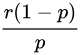

In [171]:
def SEIR_M_St(params, pop, initials, M, T, dt=1, nbi_r = False):
    """
    SEIR model with migration
    :param params: list of parameters [R0, Z, D]
    :param pop: population size of each location
    :param initials: list of initial values [start_pos, E0]
    :param M: migration matrix
    :param T: number of time steps
    :param dt: time step size
    """
    # Parameters
    R0 = params[0]
    Z = params[1]
    D = params[2]

    start_pos, E0 = initials
    N = len(pop)  # number of locations
    # initialize
    NewInf = np.zeros((N, T))
    NewInf[start_pos, 0] = E0
    x = np.zeros((N, 4))  # S, E, I for three populations
    x[:, 0] = pop
    x[start_pos, 0] = pop[start_pos] - E0  # Susceptibles
    x[start_pos, 1] = E0  # Exposed
    
    # Define distributions
    if nbi_r:
        def infection_distribution(mean_newinf):
            p = nbi_r / (mean_newinf + nbi_r)
            newinf = np.random.negative_binomial(nbi_r, p)
            return newinf
    else:
        def infection_distribution(mean_newinf):
            return np.random.poisson(mean_newinf)
        
    
    for t in range(1, T):  # Starting from 1 because we already initialized NewInf at time 0
        #         print(t)
        for _ in range(int(1 / dt)):
            S = x[:, 0]
            E = x[:, 1]
            I = x[:, 2]
            R = x[:, 3]
    #             x_new = x.copy()
            ds_expected = - R0 / D * S * I / pop
    #             NewInf[:, t] += infection
#             NewInf[:, t] = - ds  # x[:, 1]/Z #ds
            mean_newinf = - ds_expected #x[:, 1]/Z #ds
#             NewInf[:,t] = np.random.poisson(mean_newinf)
            ds = - infection_distribution(mean_newinf) ## ds is negative 
            NewInf[:,t] = - ds
            
            de = - ds - E/Z
            di = E/Z - I/D
            dr = I/D
            S += ds*dt
            E += de*dt
            I += di*dt
            R += dr*dt
            # then travel
            s_moveout, s_movein = state_M(M, S)
            e_moveout, e_movein = state_M(M, E)
            i_moveout, i_movein = state_M(M, I)
            r_moveout, r_movein = state_M(M, R)
            S += (- s_moveout + s_movein)*dt
            E += (- e_moveout + e_movein)*dt
            I += (- i_moveout + i_movein)*dt
            R += (- r_moveout + r_movein)*dt
    return x, NewInf

In [238]:
x, NewInf = SEIR_M_St(params=[2.5,3,5], pop=pop, initials=initials, M=WN, T=60, dt=0.1, nbi_r=0.025)

In [178]:
x_p, NewInf_p = SEIR_M_St(params=[2.5,3,5], pop=pop, initials=initials, M=WN, T=60, dt=0.1, nbi_r=False)

In [200]:
def check_out(WN, NewInf):
    X = np.cumsum(NewInf,axis=1)
    Moveout = np.zeros((3142,60))
    Movein = np.zeros((3142,60))
    for t in range(60):
        S = X[:,t]
        s_moveout, s_movein = state_M(WN, S)
        Moveout[:,t] = s_moveout
        Movein[:,t] = s_movein
    return Moveout, Movein

In [239]:
Moveout, _ = check_out(WN, NewInf)
Moveout_p, _ = check_out(WN, NewInf_p)

In [240]:
C = np.zeros(60)
Flow = np.zeros(60)
for t in range(60):
    C[t] = np.sum(Moveout[:,t] != 0)
    Flow[t] = np.sum(Moveout[:,t])

In [241]:
C_p = np.zeros(60)
Flow_p = np.zeros(60)
for t in range(60):
    C_p[t] = np.sum(Moveout_p[:,t] != 0)
    Flow_p[t] = np.sum(Moveout_p[:,t])

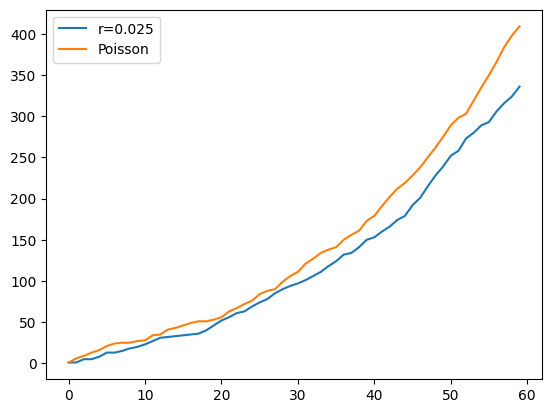

In [242]:
plt.plot(C,label='r=0.025')
plt.plot(C_p,label='Poisson')
plt.legend()

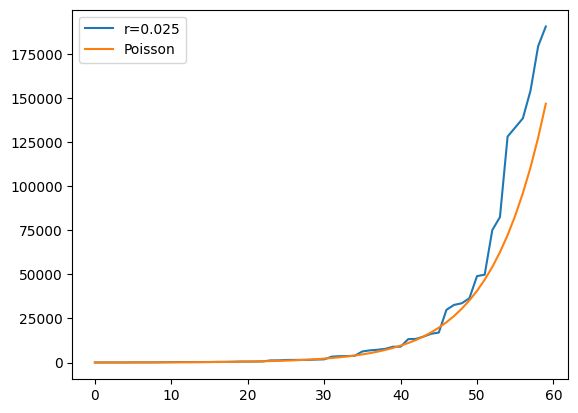

In [243]:
plt.plot(Flow,label='r=0.025')
plt.plot(Flow_p,label='Poisson')
plt.legend()

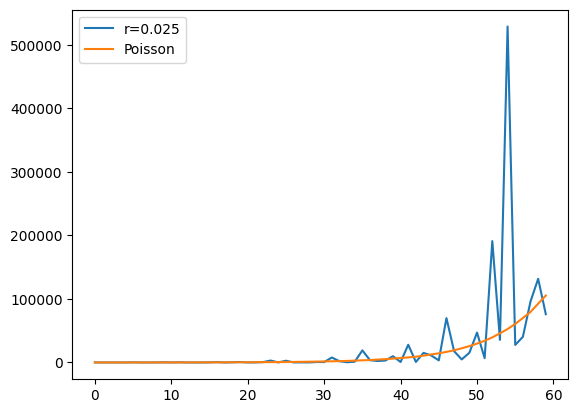

In [253]:
plt.plot(np.sum(NewInf,axis=0),label='r=0.025')
plt.plot(np.sum(NewInf_p,axis=0),label='Poisson')
plt.legend()

7206
8518


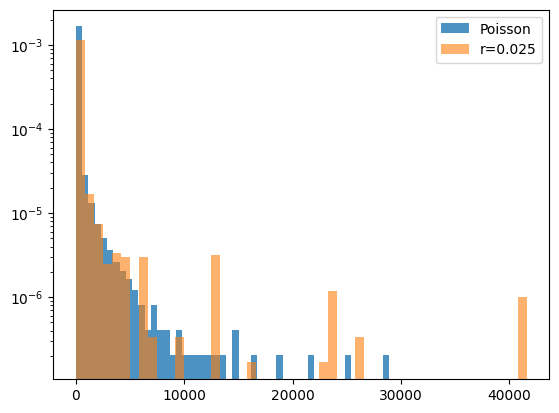

In [248]:
print(np.sum(Moveout!=0))
print(np.sum(Moveout_p!=0))

plt.hist(Moveout_p[Moveout_p!=0].ravel(),bins=50,label='Poisson',alpha=0.8,density=True)
plt.hist(Moveout[Moveout!=0].ravel(),bins=50,label='r=0.025',alpha=0.6,density=True)
plt.yscale('log')
# plt.title('no zero flow out for r={}'.format(r))
plt.legend()

In [249]:
infec_perpop = NewInf/pop[:,None]*100000
infec_perpop_p = NewInf_p/pop[:,None]*100000

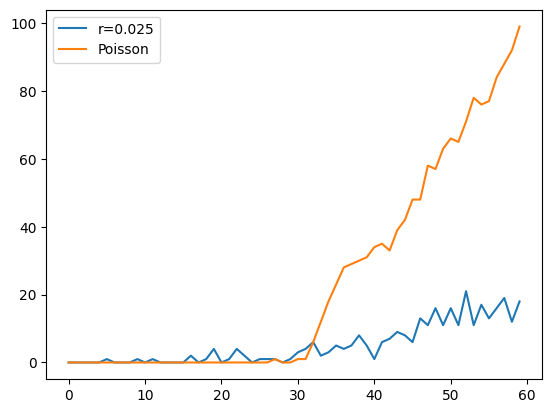

In [252]:
plt.plot(np.sum(infec_perpop>10,axis=0),label='r=0.025')
plt.plot(np.sum(infec_perpop_p>10,axis=0),label='Poisson')
plt.legend()## the WN will change the transmission a lot

In [118]:
with h5py.File('./M_stocha_poi.h5', 'r') as hf:
    loaded_results = hf['data'][:]

In [8]:
file_dir = '/Users/qingyao/../../Volumes/Seagate_Qing/branching_data/simulation/meta_stoch/dt0.1/'

In [9]:
pop = np.loadtxt('pop_new.csv')

In [10]:
loaded_results = np.zeros((300,3142,60))
sub_export_dir = file_dir+'meta_stoch_poi/'
for i in range(300):
    export_names = sub_export_dir+'New_Inf_poi_{}.csv'.format((i+1))
    temp = np.loadtxt(export_names,delimiter=',')
    if len(temp) == 1:
        print(r, i)
    else:
        loaded_results[i,:,:] = temp

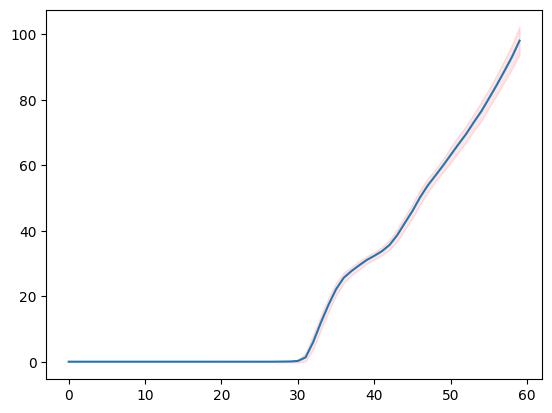

In [11]:
pop_reshaped = pop.reshape(-1, 1)

# Perform the operation using broadcasting. This will automatically expand the dimensions where needed.
infec_perpop_en = (loaded_results / pop_reshaped) * 100000

# infec_perpop_en = loaded_results/pop[:,None]*100000
num_counties_en = np.sum(infec_perpop_en>10,axis=1)
county_avg = np.mean(num_counties_en,axis=0)
county_std = np.std(num_counties_en,axis=0)
plt.plot(county_avg) ## the WN will change the transmission a lot
plt.fill_between(range(60),county_avg-county_std, county_avg + county_std, alpha=0.1,color='red')

In [12]:
rs = np.array([20.0, 1.0, 0.1, 0.025])

In [13]:
# Numcounty_mean =  {}
# Numcounty_std =  {}
Ensembles_r = {}

for r_idx in range(len(rs)): #len(rs)
    r = rs[r_idx]
    Ensembles = np.zeros((300,3142,60))
    print(r)
    sub_export_dir = file_dir+'meta_stoch_nbio_{}_v1/'.format(r_idx)
    for i in range(300):
        export_names = sub_export_dir+'New_Inf_nbi_{}_{}.csv'.format(r,(i+1))
        temp = np.loadtxt(export_names,delimiter=',')
        if len(temp) == 1:
            print(r, i)
        else:
            Ensembles[i,:,:] = temp
    Ensembles_r[r] = Ensembles

20.0
1.0
0.1
0.025


In [14]:
Ensembles_r[20.0].shape

(300, 3142, 60)

In [15]:
loaded_results_nbio = Ensembles_r[20.0]
pop_reshaped = pop.reshape(-1, 1)

# Perform the operation using broadcasting. This will automatically expand the dimensions where needed.
infec_perpop_en_nbio = (loaded_results_nbio / pop_reshaped) * 100000

# infec_perpop_en = loaded_results/pop[:,None]*100000
num_counties_en_nbio = np.sum(infec_perpop_en_nbio>10,axis=1)
county_avg_nbio = np.mean(num_counties_en_nbio,axis=0)
county_std_nbio = np.std(num_counties_en_nbio,axis=0)

In [16]:
colors = {20.0:'orange',1.0:'yellowgreen',0.1:'lightskyblue',0.025:'cornflowerblue'}
# colours_par = {0.01:'red',0.1:'purple',0.5:'darkviolet',1:'black',5:'blue',10:'cornflowerblue','inf':'skyblue','geo':'grey',0.05:'turquoise',0.02:'seagreen',0.032:'olive'}

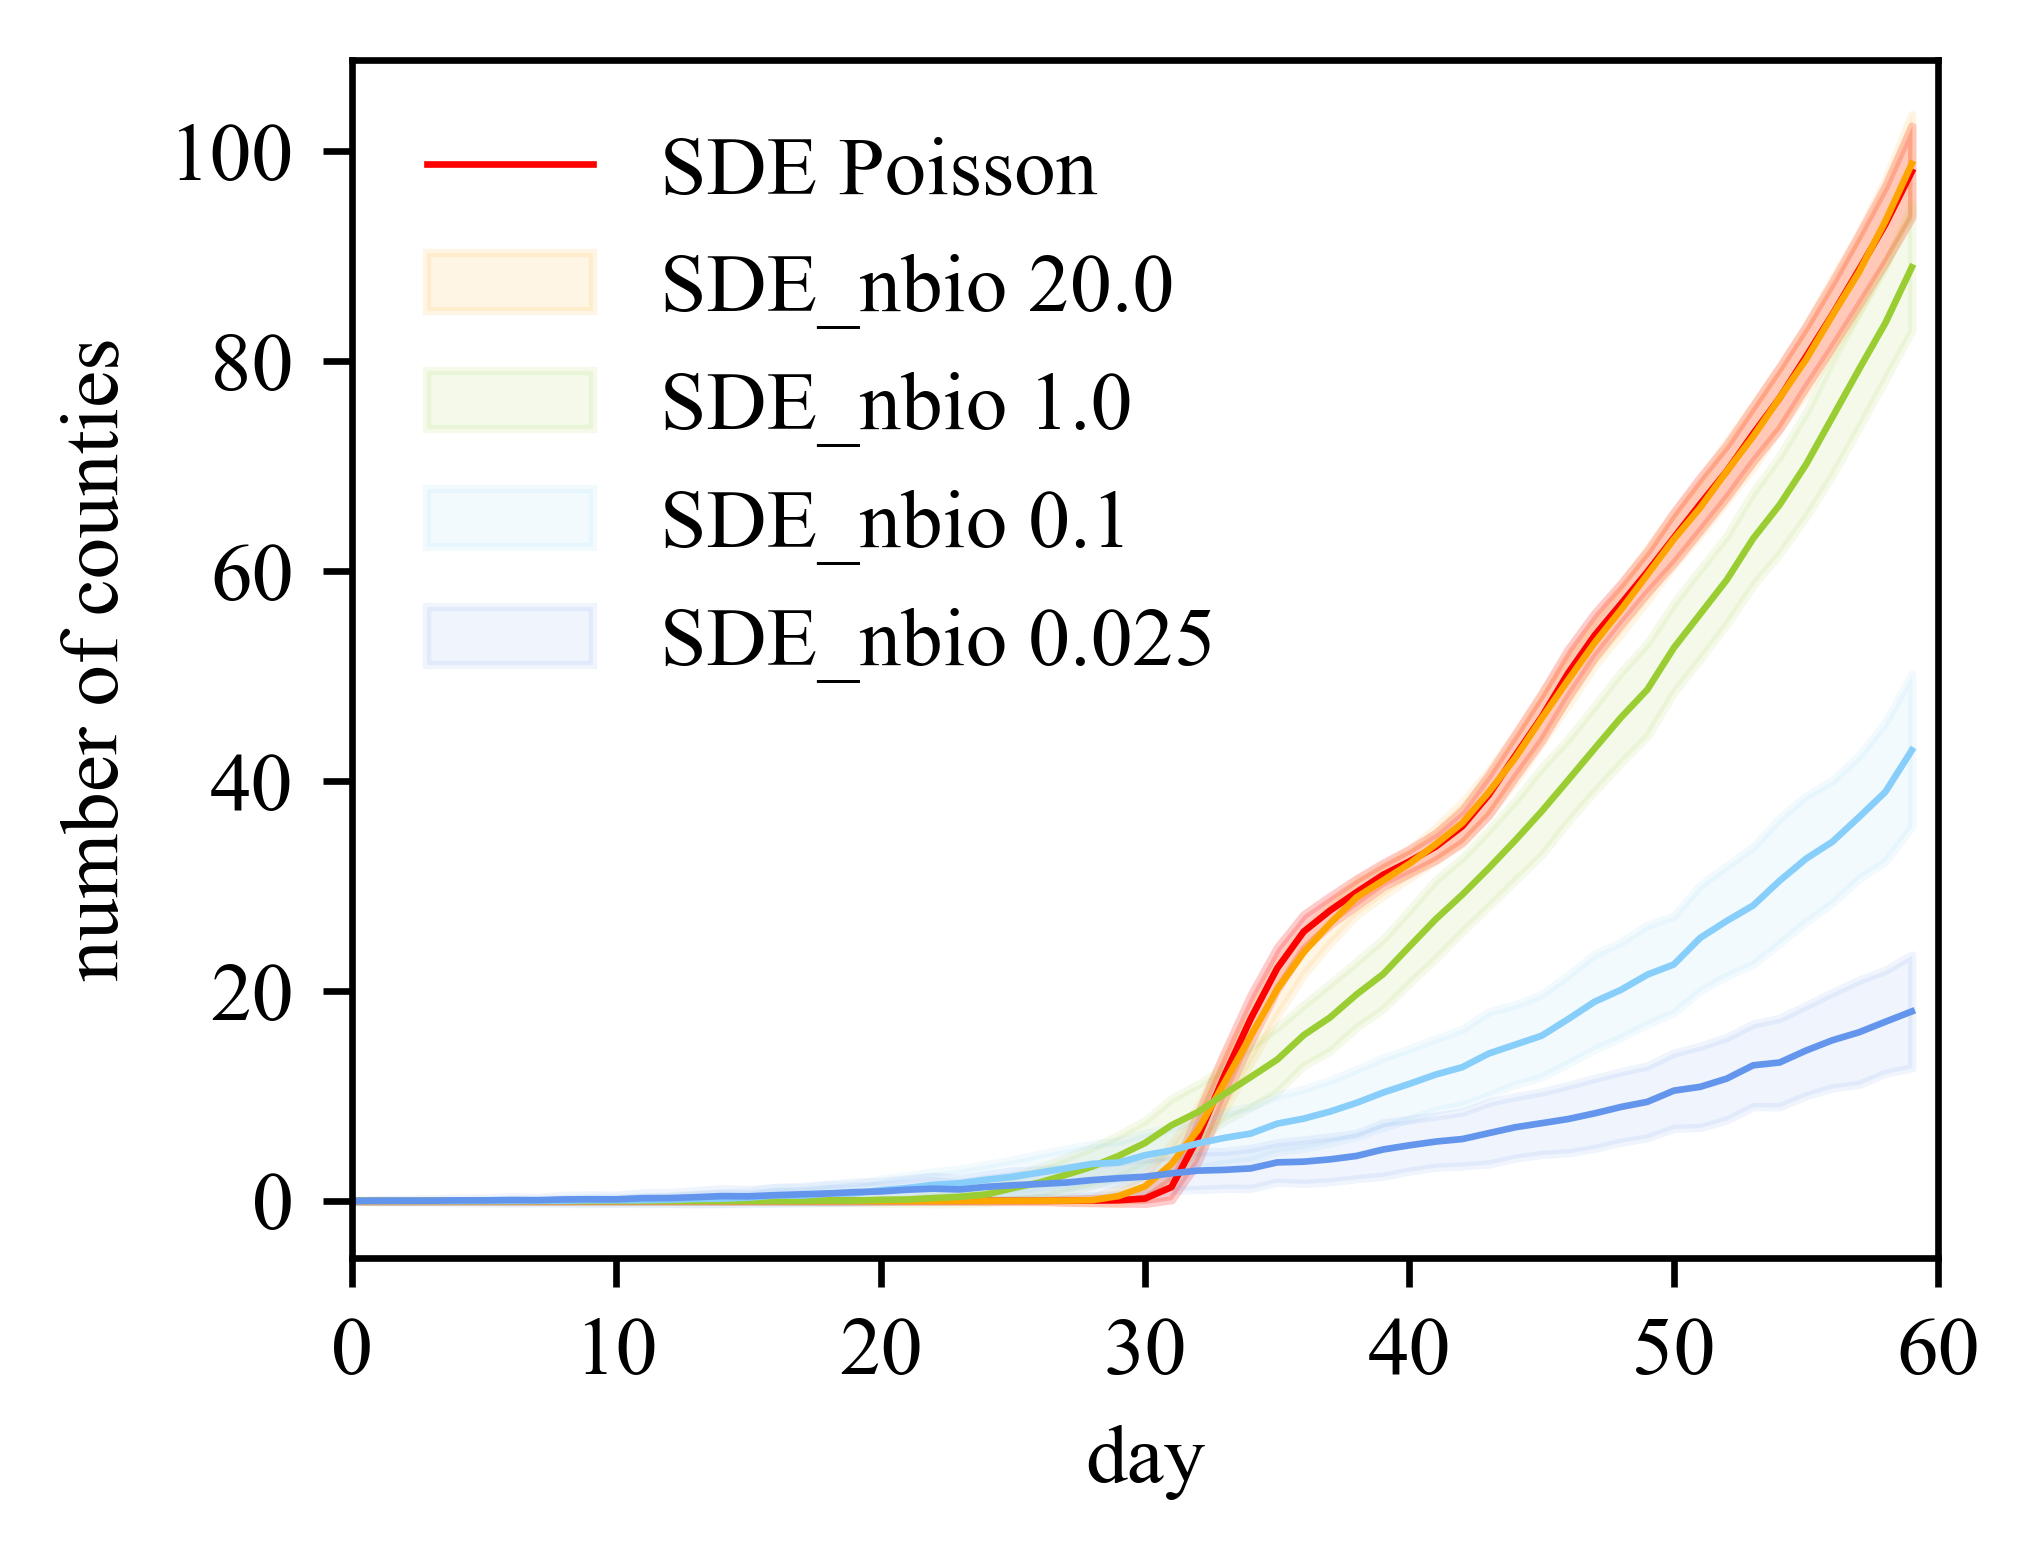

In [19]:
plt.rcParams['font.family'] = 'Times New Roman' 
plt.figure(dpi=600,figsize=(3.5,2.7))

plt.plot(county_avg,c='red',label='SDE Poisson',lw=0.8) ## the WN will change the transmission a lot
plt.fill_between(range(60),county_avg -county_std, 
                 county_avg + county_std, alpha=0.2,color='red')

for r in rs:
    loaded_results_nbio = Ensembles_r[r]
    pop_reshaped = pop.reshape(-1, 1)

    # Perform the operation using broadcasting. This will automatically expand the dimensions where needed.
    infec_perpop_en_nbio = (loaded_results_nbio / pop_reshaped) * 100000

    # infec_perpop_en = loaded_results/pop[:,None]*100000
    num_counties_en_nbio = np.sum(infec_perpop_en_nbio>10,axis=1)
    county_avg_nbio = np.mean(num_counties_en_nbio,axis=0)
    county_std_nbio = np.std(num_counties_en_nbio,axis=0)
    plt.plot(county_avg_nbio,c=colors[r],lw=0.8) ## the WN will change the transmission a lot
    plt.fill_between(range(60),county_avg_nbio-county_std_nbio, 
                     county_avg_nbio + county_std_nbio, color=colors[r], 
                     alpha=0.1,label='SDE_nbio {}'.format(r))

plt.legend(frameon=False)
plt.xlabel('day',size=10)
plt.ylabel('number of counties',size=10)
plt.xlim(0,60)
plt.tight_layout()

# plt.ylim(-1,40)
plt.savefig('sde.pdf',bbox_inches='tight')
# plt.savefig('sde.eps',bbox_inches='tight',format='eps')

In [235]:
all_t1 = np.mean(np.sum(Ensembles_r[20.0],axis=1),axis=0)
all_t2 = np.mean(np.sum(Ensembles_r[0.025],axis=1),axis=0)

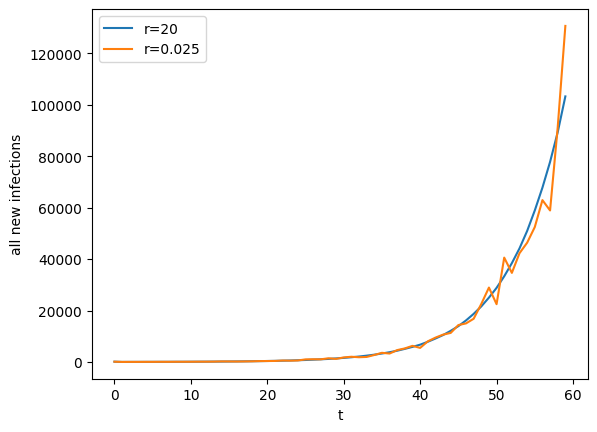

In [236]:
plt.plot(all_t1,label='r=20')
plt.plot(all_t2,label='r=0.025')
plt.xlabel('t')
plt.ylabel('all new infections')
plt.legend()

In [156]:
file_dir = '/Users/qingyao/Documents/branching_data/simulation/meta_stoch/dt1/'

In [158]:
Ensembles_r = {}

for r_idx in range(len(rs)): #len(rs)
    r = rs[r_idx]
    Ensembles = np.zeros((300,3142,60))
    print(r)
    sub_export_dir = file_dir+'meta_stoch_nbio_{}/'.format(r_idx)
    for i in range(300):
        export_names = sub_export_dir+'New_Inf_nbi_{}_{}.csv'.format(r,(i+1))
        temp = np.loadtxt(export_names,delimiter=',')
        if len(temp) == 1:
            print(r, i)
        else:
            Ensembles[i,:,:] = temp
    Ensembles_r[r] = Ensembles

20.0
1.0
0.1
0.025


Text(0.5, 1.0, 'dt=1')

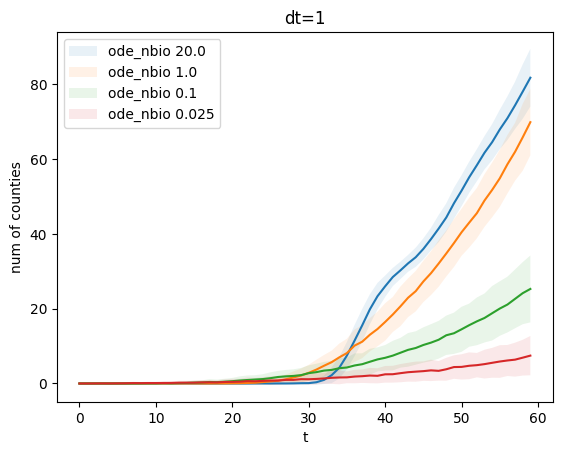

In [160]:
# plt.plot(county_avg,c='red',label='poission') ## the WN will change the transmission a lot
# plt.fill_between(range(60),county_avg -county_std, 
#                  county_avg + county_std, alpha=0.2,color='red')

for r in rs:
    loaded_results_nbio = Ensembles_r[r]
    pop_reshaped = pop.reshape(-1, 1)

    # Perform the operation using broadcasting. This will automatically expand the dimensions where needed.
    infec_perpop_en_nbio = (loaded_results_nbio / pop_reshaped) * 100000

    # infec_perpop_en = loaded_results/pop[:,None]*100000
    num_counties_en_nbio = np.sum(infec_perpop_en_nbio>10,axis=1)
    county_avg_nbio = np.mean(num_counties_en_nbio,axis=0)
    county_std_nbio = np.std(num_counties_en_nbio,axis=0)
    plt.plot(county_avg_nbio) ## the WN will change the transmission a lot
    plt.fill_between(range(60),county_avg_nbio-county_std_nbio, 
                     county_avg_nbio + county_std_nbio, alpha=0.1,label='ode_nbio {}'.format(r))
plt.legend()
plt.xlabel('t')
plt.ylabel('num of counties')
plt.title('dt=1')

In [161]:
all_t1 = np.mean(np.sum(Ensembles_r[20.0],axis=1),axis=0)
all_t2 = np.mean(np.sum(Ensembles_r[0.025],axis=1),axis=0)

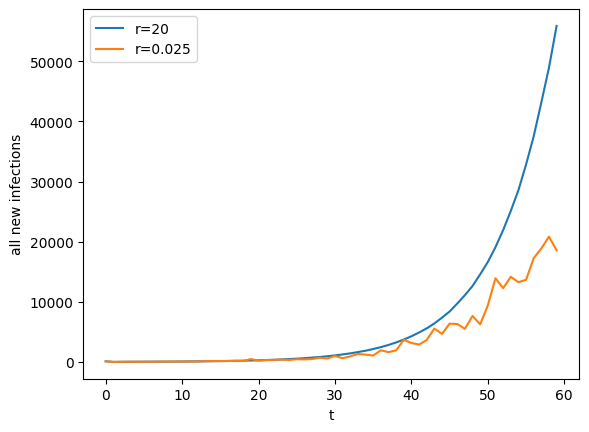

In [162]:
plt.plot(all_t1,label='r=20')
plt.plot(all_t2,label='r=0.025')
plt.xlabel('t')
plt.ylabel('all new infections')
plt.legend()